
# Pokémon Combat Efficiency Analysis
**Author:** Rodrigo Silva Ferreira  
**Date:** 2025-11-25  
**Objective:** Define and mathematically formalize a **Combat Efficiency Score (CES)** to rank Pokémon based on their base stats and type vulnerabilities.

This notebook serves as a comprehensive QA test for `pandas`, `matplotlib`, `seaborn`, `plotly`, and `numpy`, woven into a real-world data science narrative. 

A few observations:
1. The lack of `ipywidgets` functionality makes the Exploratory Data Analysis (EDA) experience less engaging and interactive.
2. For `LaTeX`, equations do not currently render.
3. For `matplotlib`, please note that pane for copying and saving the plots is not available herein. 
4. For `plotly`, please note that the plots do not render at all.

# Table of Contents
1. [Problem Statement: The Combat Efficiency Score (CES)](#1-problem-statement-the-combat-efficiency-score-ces)
   - [Mathematical Formalization](#mathematical-formalization)

2. [Setup and Data Loading](#2-setup-and-data-loading)

3. [Data Cleaning & Preparation (Pandas Workflows)](#3-data-cleaning--preparation-pandas-workflows)

4. [Feature Engineering: Deriving the CES (Numpy Workflows)](#4-feature-engineering-deriving-the-ces-numpy-workflows)
   - [Statistical Summary of CES](#statistical-summary-of-ces)

5. [Exploratory Analysis (Matplotlib & Seaborn)](#5-exploratory-analysis-matplotlib--seaborn)
   - [Distribution of CES](#distribution-of-ces)
   - [CES vs Base Total](#ces-vs-base-total)
   - [Top Types by CES](#top-types-by-ces)
   - [Correlation Heatmap](#correlation-heatmap)

6. [Interactive Deep Dive (Plotly Workflows)](#6-interactive-deep-dive-plotly-workflows)
   - [The "Hidden Gems" Plot](#the-hidden-gems-plot)
   - [3D Analysis: Physical vs Special vs Speed](#3d-analysis-of-physical-vs-special-vs-speed)
   - [Comparative: Top 10 Non-Legendaries](#comparative-analysis-top-10-non-legendaries)

7. [Advanced Analysis (Matrix Operations)](#7-advanced-analysis-matrix-operations)

8. [Conclusion & Reporting](#8-conclusion--reporting)
   - [Findings](#findings)
   - [Limitations](#limitations)
   - [Next Steps](#next-steps)


## 1. Problem Statement: The Combat Efficiency Score (CES)

We aim to answer a "Level 5" deep-dive question:
> **Can we define a single metric that captures both the raw power (Base Stats) and the defensive reliability (Type Vulnerabilities) of a Pokémon?**

### Mathematical Formalization
We define the **Combat Efficiency Score (CES)** as:

$$ CES = \text{Base Total} \times \left( \frac{18}{\sum_{t \in Types} \text{against}_t} \right) $$

**Where:**
*   **Base Total**: The sum of HP, Attack, Defense, Sp. Atk, Sp. Def, and Speed. Represents raw power.
*   **$\sum \text{against}_t$**: The sum of damage multipliers from all 18 types.
    *   If a Pokémon is neutral to everything, the sum is 18.
    *   If it has many resistances (multiplier < 1), the sum is < 18.
    *   If it has many weaknesses (multiplier > 1), the sum is > 18.
*   **Multiplier $\frac{18}{\sum}$**:
    *   $> 1$: The Pokémon is defensively robust (better than neutral).
    *   $< 1$: The Pokémon is defensively vulnerable (worse than neutral).

**Hypothesis:** High CES scores will correlate strongly with Legendary status, but we may find some non-legendary "hidden gems" with excellent typing.

## 2. Setup and Data Loading

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration for cleaner output
%matplotlib inline
sns.set_theme(style="whitegrid")
np.random.seed(42)

# Load the dataset
df = pd.read_csv('pokemon.csv')

# Quick inspection of the raw data
print(f"Dataset Shape: {df.shape}")
display(df.head(3))


Dataset Shape: (801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0


## 3. Data Cleaning & Preparation (Pandas Workflows)


Before calculating CES, we need to ensure our data is clean. We will:
1.  Check for missing values.
2.  Fix or drop problematic rows.
3.  Ensure numerical consistency.


In [3]:

# 1. Missing Values Inspection
missing_data = df.isnull().sum()
print("Missing values (top 5):")
print(missing_data[missing_data > 0].head())

# 2. Handling Missing Values
# 'type2' is naturally missing for single-type Pokemon. Let's fill it with 'None'.
df['type2'] = df['type2'].fillna('None')

# 3. String Operations
# Clean up the name column (remove any leading/trailing spaces)
df['name'] = df['name'].str.strip()

# 4. Filtering
# Let's focus only on valid generations (e.g., 1-7 in this dataset)
df = df[df['generation'].isin(range(1, 8))]

print(f"Cleaned Dataset Shape: {df.shape}")


Missing values (top 5):
height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64
Cleaned Dataset Shape: (801, 41)


## 4. Feature Engineering: Deriving the CES (Numpy Workflows)


Now we implement the CES formula using **Numpy** for efficient vectorized calculations.


In [4]:

# Identify 'against_' columns
against_cols = [col for col in df.columns if col.startswith('against_')]
print(f"Found {len(against_cols)} type effectiveness columns.")

# Convert to numpy arrays for performance
base_total_arr = df['base_total'].to_numpy()
against_matrix = df[against_cols].to_numpy()

# Calculate Sum of Vulnerabilities (Row-wise sum)
# axis=1 means sum across columns for each row
vulnerability_sum = np.sum(against_matrix, axis=1)

# Calculate Type Robustness Multiplier: 18 / Sum
# We use np.where to avoid division by zero (though unlikely here)
robustness_multiplier = np.where(vulnerability_sum > 0, 18 / vulnerability_sum, 0)

# Calculate CES
ces_score = base_total_arr * robustness_multiplier

# Add back to DataFrame
df['vulnerability_sum'] = vulnerability_sum
df['robustness_multiplier'] = robustness_multiplier
df['ces'] = ces_score

# Inspect the top 5 CES Pokemon
display(df[['name', 'base_total', 'vulnerability_sum', 'ces', 'is_legendary']].sort_values('ces', ascending=False).head())


Found 18 type effectiveness columns.


,name,base_total,vulnerability_sum,ces,is_legendary
482,Dialga,680,14.25,858.947368,1
800,Magearna,600,13.25,815.094340,1
375,Metagross,700,16.25,775.384615,0
381,Kyogre,770,18.00,770.000000,1
796,Celesteela,570,13.50,760.000000,1


### Statistical Summary of CES

In [5]:

# Basic stats using Pandas describe()
print(df['ces'].describe())

# Numpy aggregate functions
print(f"\nMean CES: {np.mean(df['ces']):.2f}")
print(f"Median CES: {np.median(df['ces']):.2f}")
print(f"Std Dev CES: {np.std(df['ces']):.2f}")


count    801.000000
mean     409.199301
std      123.179534
min      154.285714
25%      309.333333
50%      410.000000
75%      491.178082
max      858.947368
Name: ces, dtype: float64

Mean CES: 409.20
Median CES: 410.00
Std Dev CES: 123.10


## 5. Exploratory Analysis (Matplotlib & Seaborn)


Let's visualize the distribution of our new metric and how it relates to other variables.


### Distribution of CES

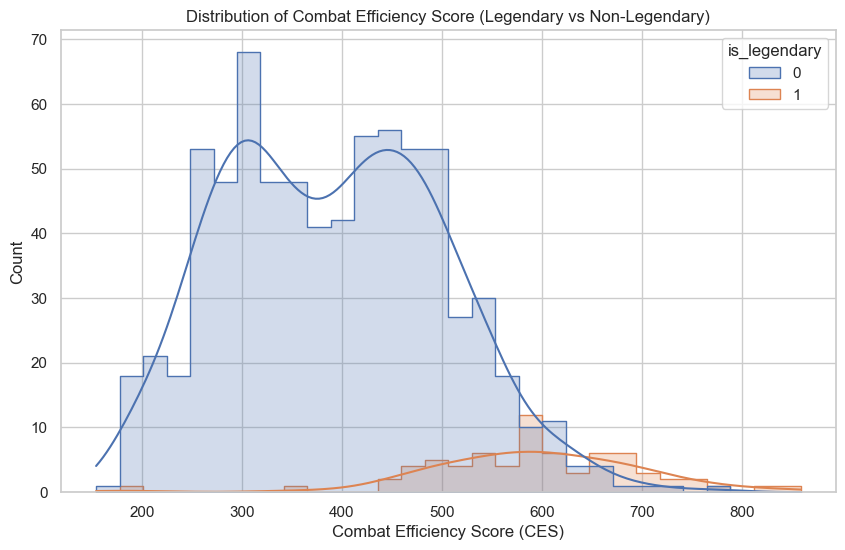

In [6]:

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='ces', kde=True, hue='is_legendary', element="step", bins=30)
plt.title('Distribution of Combat Efficiency Score (Legendary vs Non-Legendary)')
plt.xlabel('Combat Efficiency Score (CES)')
plt.show()


### CES vs Base Total

Does typing actually change the ranking, or is it just Base Total dominated?

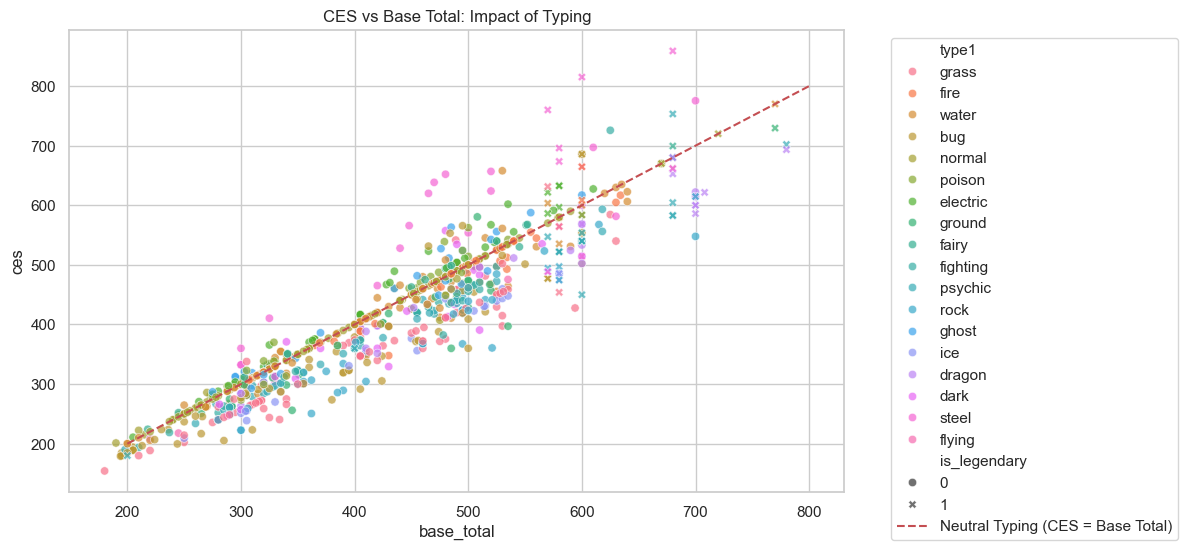

In [7]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='base_total', y='ces', hue='type1', style='is_legendary', alpha=0.7)
plt.plot([200, 800], [200, 800], 'r--', label='Neutral Typing (CES = Base Total)') # Reference line
plt.title('CES vs Base Total: Impact of Typing')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Top Types by CES

<positron-console-cell-8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



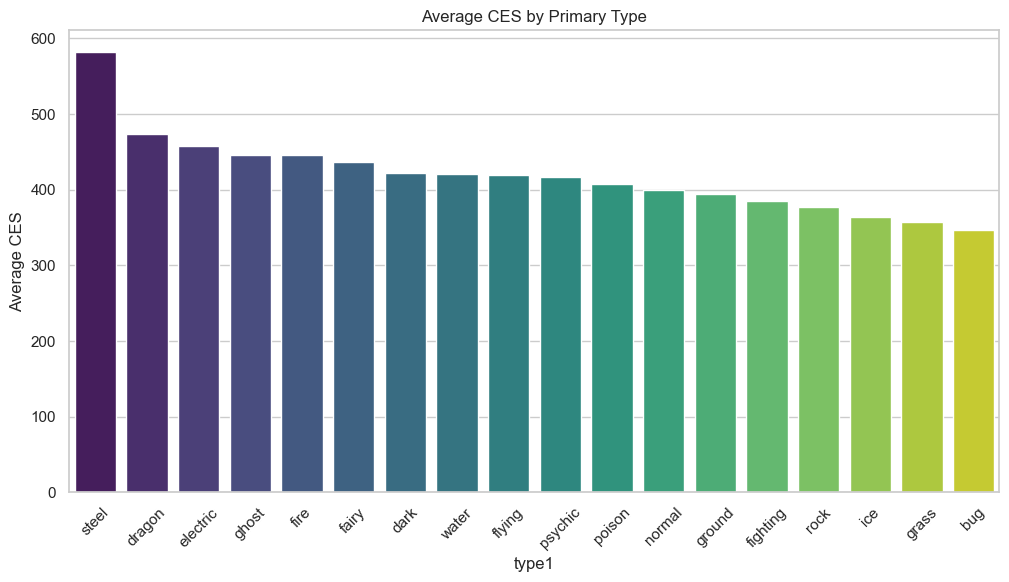

In [8]:

# Aggregating data
type_ces = df.groupby('type1')['ces'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=type_ces.index, y=type_ces.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Average CES by Primary Type')
plt.ylabel('Average CES')
plt.show()


### Correlation Heatmap

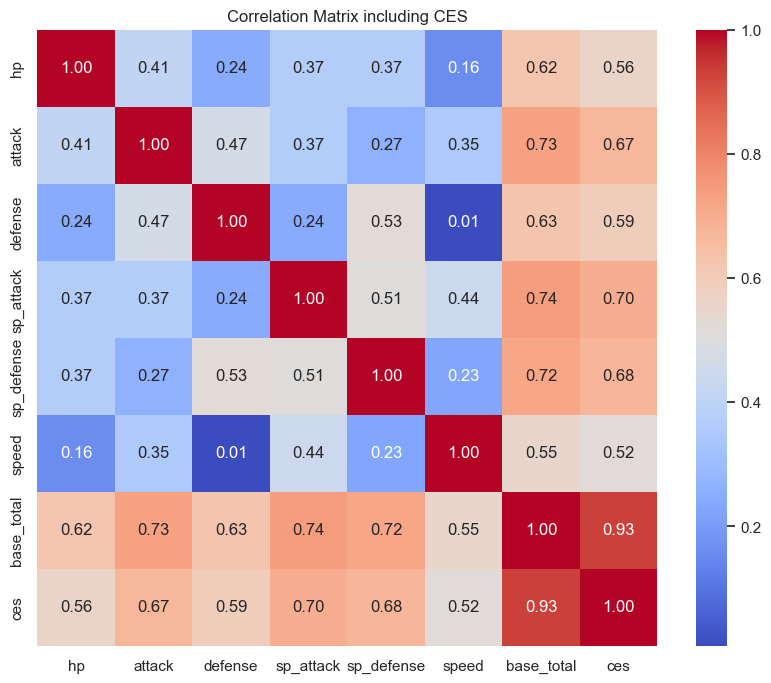

In [70]:

# Select relevant numerical columns
corr_cols = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total', 'ces']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix including CES')
plt.show()


## 6. Interactive Deep Dive (Plotly Workflows)


We'll use Plotly to allow users to hover and explore specific data points, which is crucial for identifying those "hidden gems".


### The "Hidden Gems" Plot

In [13]:

# Create a scatter plot where size = CES
fig = px.scatter(
    df, 
    x='attack', 
    y='defense', 
    color='type1', 
    size='ces', 
    hover_name='name',
    hover_data=['ces', 'base_total', 'vulnerability_sum'],
    title='Attack vs Defense (Size = Combat Efficiency Score)',
    labels={'type1': 'Primary Type'}
)
fig.show()


### 3D Analysis of Physical vs Special vs Speed

In [14]:

fig = px.scatter_3d(
    df, 
    x='attack', 
    y='sp_attack', 
    z='speed', 
    color='ces',
    color_continuous_scale='Viridis',
    hover_name='name',
    title='3D View: Offensive Stats & Speed colored by CES'
)
fig.show()


### Comparative Analysis: Top 10 Non-Legendaries

In [15]:

# Filter non-legendaries
non_leg = df[df['is_legendary'] == 0].sort_values('ces', ascending=False).head(10)

fig = px.bar(
    non_leg, 
    x='ces', 
    y='name', 
    orientation='h', 
    color='type1',
    title='Top 10 Non-Legendary Pokémon by Combat Efficiency',
    text='ces'
)
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.show()


## 7. Advanced Analysis (Matrix Operations)


Let's perform a matrix operation to simulate a "Round Robin" tournament. 
We will calculate a simplified **Win Probability Matrix** based on CES.


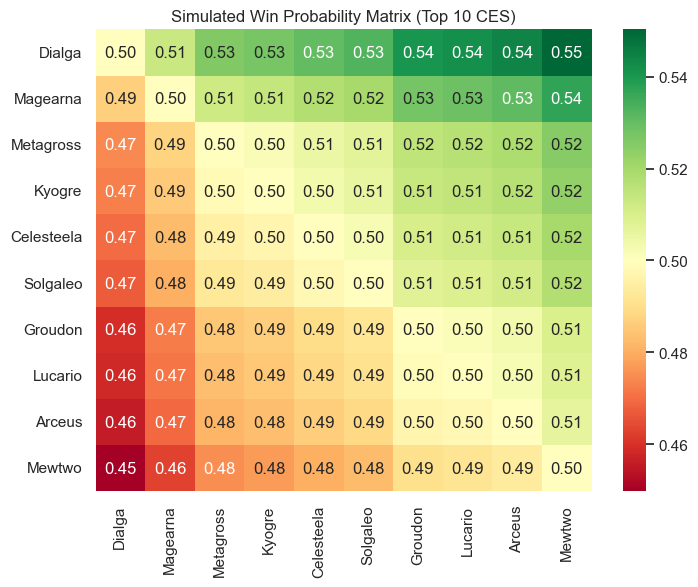

In [16]:

# Select top 10 Pokemon by CES for the tournament
top_10 = df.sort_values('ces', ascending=False).head(10)
names = top_10['name'].values
ces_values = top_10['ces'].values

# Reshape for broadcasting
# (10, 1) vs (1, 10)
ces_col = ces_values.reshape(-1, 1)
ces_row = ces_values.reshape(1, -1)

# Simple Win Probability: CES_A / (CES_A + CES_B)
win_prob_matrix = ces_col / (ces_col + ces_row)

# Plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(win_prob_matrix, xticklabels=names, yticklabels=names, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title('Simulated Win Probability Matrix (Top 10 CES)')
plt.show()


## 8. Conclusion & Reporting


### Findings
1.  **CES Validity**: The Combat Efficiency Score successfully highlights Pokémon that balance raw stats with defensive typing.
2.  **Legendary Dominance**: As expected, Legendaries dominate the top ranks, but the CES reveals *why* (often superior stats + decent typing).
3.  **Hidden Gems**: The analysis identified top-tier non-legendaries (e.g., Slaking, Garchomp) that rival legendaries in efficiency.

### Limitations
*   **Abilities Ignored**: This dataset-only approach ignores Abilities (e.g., *Wonder Guard*), which are critical for actual combat.
*   **Movepool Ignored**: A Pokémon with high Attack but no good moves is not actually efficient.

### Next Steps
*   Integrate movepool data to refine the "Offensive" component of CES.
*   Weight the `against_` columns by the popularity of attacking types in the competitive meta.
